In [12]:
import pandas as pd
import numpy as np

stocks = pd.read_csv("stocks/stocks.csv")
stocks.select_dtypes(exclude=['int', 'float']).columns

Index(['Name', 'NSE Code', 'Industry', 'join_key'], dtype='object')

## Remove columns with more than 400 missing values

In [13]:
stocks.isna().sum()

Name                                0
BSE Code                            0
NSE Code                            0
Industry                            0
Current Price 1                     1
                                 ... 
NCAVPS                             38
Market Capt to Cash Flow           46
Altman Z Score                     39
Market cap to quarterly profit    522
Market Capitalization               0
Length: 385, dtype: int64

In [14]:
missing_values = stocks.isna().sum()
cols_to_drop = list(missing_values[missing_values > 400].index)
stocks = stocks.drop(cols_to_drop, axis=1)

## Remove rows with more than 20 missing values

In [15]:
stocks.isna().sum(axis=1)

0        0
1        2
2        0
3        0
4       32
        ..
4663     0
4664     0
4665     0
4666     0
4667     0
Length: 4668, dtype: int64

In [16]:
missing_values = stocks.isna().sum(axis=1)
rows_to_drop = missing_values[missing_values > 20].index
stocks = stocks.drop(rows_to_drop)

## Take max of current price and mean of market cap since there are too many columns of both

In [17]:
price_cols = [col for col in stocks.columns if col.startswith("Current Price")]
market_cap_cols = [col for col in stocks.columns if col.startswith("Market Capitalization")]

stocks['Current Price Final'] = stocks[price_cols].max(axis=1, skipna=True)
stocks["Market Capitalization Final"] = stocks[market_cap_cols].mean(axis=1, skipna=True)

stocks.drop(price_cols + market_cap_cols, axis=1, inplace=True)
stocks.rename(columns={"Current Price Final": "Current Price", "Market Capitalization Final": "Market Capitalization"}, inplace=True)

## Save as preprocessed dataframe

In [18]:
stocks.to_csv("stocks/stocks_cleaned.csv", index=False)

## Encode and impute

In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

stocks = pd.read_csv("stocks/stocks_cleaned.csv")
x, y = stocks.drop(["Name", "BSE Code", "NSE Code", "join_key", "t_1_price"], axis=1), stocks["t_1_price"]

encoder = LabelEncoder()
imputer = IterativeImputer(random_state=42)

x['Industry'] = encoder.fit_transform(x['Industry'])
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)
x["Graham"] = (22.5 * x["EPS"] * x["Book value"]) ** 0.5
x.Graham.fillna(0, inplace=True)

## Feature importance and selection

In [56]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt
import seaborn as sns

def score_dataset(x, y, model):
    x = x.copy()
    return cross_val_score(model, x, y).mean()

def make_mi_scores(x, y):
    x = x.copy()
    discrete = x.dtypes == int
    return pd.Series(mutual_info_regression(x, y, discrete_features=discrete, random_state=42), index=x.columns).sort_values(ascending=False)

def plot_scores(scores, n, high=True):
    plt.figure(figsize=(5, 5))
    plt.title('Mutual Information')
    if high:
        sns.barplot(x=scores[:n], y=scores.index[:n])
    else:
        sns.barplot(x=scores[(-1 * n):], y=scores.index[(-1 * n):])
    plt.ylabel('Features')
    plt.xlabel('Score')

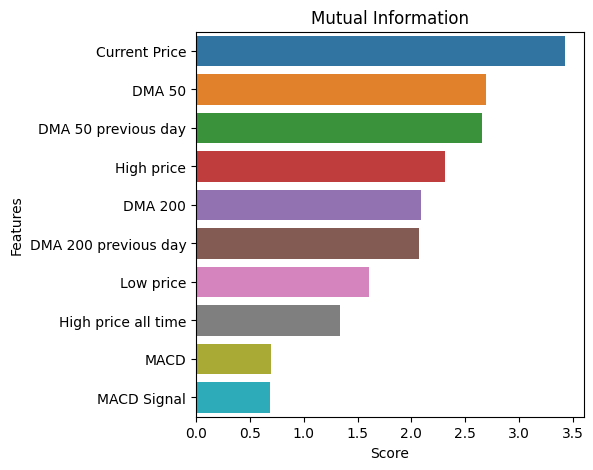

In [21]:
scores = make_mi_scores(x, y)
plot_scores(scores, 10)

In [57]:
features = scores[scores < 0.25].index
x_temp = x.drop(features, axis=1)
score_dataset(x_temp, y, Ridge(random_state=42))

0.9766963179723595

### Tuning of feature selection

In [67]:
import optuna

def objective(trial):
    threshold = trial.suggest_float("threshold", 0, 0.9)

    features = scores[scores < threshold].index
    x_temp = x.drop(features, axis=1)
    
    return round(score_dataset(x_temp, y, Ridge(random_state=42)), 6)

study = optuna.create_study(direction="maximize")
study.enqueue_trial({"threshold": 0.25})
study.optimize(objective, n_trials=100)
study.best_trial

[I 2024-07-23 19:34:47,424] A new study created in memory with name: no-name-f1e2050c-5e43-4f34-8882-a2a18d715978
[I 2024-07-23 19:34:47,524] Trial 0 finished with value: 0.976775 and parameters: {'threshold': 0.25}. Best is trial 0 with value: 0.976775.
[I 2024-07-23 19:34:47,592] Trial 1 finished with value: 0.983343 and parameters: {'threshold': 0.539846968020957}. Best is trial 1 with value: 0.983343.
[I 2024-07-23 19:34:47,659] Trial 2 finished with value: 0.976511 and parameters: {'threshold': 0.31618720063053296}. Best is trial 1 with value: 0.983343.
[I 2024-07-23 19:34:47,728] Trial 3 finished with value: 0.983343 and parameters: {'threshold': 0.5348052208299575}. Best is trial 1 with value: 0.983343.
[I 2024-07-23 19:34:47,764] Trial 4 finished with value: 0.988583 and parameters: {'threshold': 0.7114465116099608}. Best is trial 4 with value: 0.988583.
[I 2024-07-23 19:34:47,809] Trial 5 finished with value: 0.988583 and parameters: {'threshold': 0.7451790407295663}. Best is 

FrozenTrial(number=92, state=1, values=[0.994084], datetime_start=datetime.datetime(2024, 7, 23, 19, 34, 53, 984949), datetime_complete=datetime.datetime(2024, 7, 23, 19, 34, 54, 31724), params={'threshold': 0.6775112677500316}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'threshold': FloatDistribution(high=0.9, log=False, low=0.0, step=None)}, trial_id=92, value=None)

In [58]:
threshold = 0.6775112677500316

features = scores[scores < threshold].index
x_new = x.drop(features, axis=1)
score_dataset(x_new, y, Ridge(random_state=42))

0.9940896905773056

## Model fitting

In [59]:
regressor = Ridge(random_state=42)
regressor.fit(x_new, y)

weights = regressor.coef_
feature_importances = np.abs(weights)
feature_importances = feature_importances / feature_importances.sum()
importances = sorted([[name, importance] for name, importance in zip(x_new.columns, feature_importances)], key=lambda x: x[1], reverse=True)

for i in range(len(importances)):
    if weights[i] < 0:
        importances[i][1] *= -1
    print(importances[i][0] + ": " + str(importances[i][1]))

MACD Signal: -0.24749079020506665
DMA 200: -0.2033172440560217
DMA 200 previous day: 0.1955277793771166
MACD Signal Previous Day: -0.16980654011562576
MACD: 0.06554209316688767
DMA 50: 0.054484588127231094
DMA 50 previous day: -0.048140070464957524
Current Price: -0.011552411633995925
Low price: 0.0020845505019675384
High price: -0.001977112730099701
High price all time: 7.681962102975244e-05


## Score the stocks by prediction error and growth

In [60]:
x_temp = x_new.copy()
x_temp.loc[:, "Current Price"] = y

x_new["t_1_price_predicted"] = regressor.predict(x_new)
x_new["t_1_price_actual"] = y

x_new["error"] = x_new.apply(lambda row: max(row['t_1_price_predicted'] - row['t_1_price_actual'], 0), axis=1) * 100 / x_new['t_1_price_actual']

x_new["t_2_price"] = regressor.predict(x_temp)
x_new["growth"] = (x_new["t_2_price"] - x_new["Current Price"]) * 100 / x_new["Current Price"]

x_new["score"] = x_new["growth"] - x_new["error"]

for col in ["Graham", "Altman Z Score", "Piotroski score"]:
    x_new[col] = x[col]
x_new["join_key"] = stocks["join_key"]

## Save as prediction dataframe

In [61]:
x_new.to_csv("stocks/prediction.csv", index=False)

In [62]:
df = pd.read_csv("stocks/prediction.csv")

## Shortlist stocks in four different ways and save as shortlist dataframe

In [63]:
df["cumulative"] = df["score"] + df["MACD"] - df["MACD Signal"] + 0.1 * (df["Graham"] - df["Current Price"])

In [64]:
shortlist1 = df[df.score > 30]

shortlist2 = df[(df["Current Price"] < df["Graham"]) & (df["MACD"] > df["MACD Signal"]) & (df["score"] > 15)]

shortlist3 = df[(df["Altman Z Score"] > 3) & (df["Piotroski score"] >= 8) & (df["Graham"] > df["Current Price"]) & (df["MACD"] > df["MACD Signal"]) & (df["score"] > 0)]

shortlist4 = df[df["score"] > 0].sort_values(by="cumulative", ascending=False).iloc[:20, :]

In [65]:
shortlist1.to_csv("shortlists/shortlist1.csv", index=False)
shortlist2.to_csv("shortlists/shortlist2.csv", index=False)
shortlist3.to_csv("shortlists/shortlist3.csv", index=False)
shortlist4.to_csv("shortlists/shortlist4.csv", index=False)

## Build portfolio proportionally by score, compute units to be bought and amount spent

In [71]:
def portfolio(shortlist):
    shortlist["units"] = ((shortlist["score"] * 1000000) / (shortlist["score"].sum() * shortlist["Current Price"])).round().astype(int)
    shortlist["spent"] = shortlist["units"] * shortlist["Current Price"]
    shortlist["appreciation"] = shortlist["spent"] * (100 + shortlist["growth"]) / 100
    shortlist = shortlist[shortlist["units"] != 0]
    shortlist = shortlist[["join_key", "Current Price", "t_2_price", "score", "cumulative", "units", "spent", "appreciation"]]
    return shortlist

portfolios = []
for i in range(1, 5):
    shortlist = pd.read_csv(f"shortlists/shortlist{i}.csv")
    portfolios.append(portfolio(shortlist))

In [72]:
portfolios[3]

,join_key,Current Price,t_2_price,score,cumulative,units,spent,appreciation
0,509470.0___NA__,35376.60,37808.013780,6.872944,2956.456876,1,35376.60,37808.013780
2,533095.0___NA__,8471.00,9101.297183,6.159210,1654.780172,4,33884.00,36405.188730
3,523204.0_ABAN,65.53,108.976381,2.120888,450.895381,165,10812.45,17981.102838
4,508670.0___NA__,4258.50,4775.743912,12.146153,411.667436,15,63877.50,71636.158686
5,533302.0_KICL,6479.40,6774.539643,3.349077,269.561010,3,19438.20,20323.618928
6,500780.0_ZUARIIND,409.80,452.809186,10.495165,243.406799,130,53274.00,58865.194204
7,526725.0_SANDESH,1553.05,1658.370204,6.781508,180.487749,22,34167.10,36484.144491
8,509845.0___NA__,597.95,710.177724,18.768747,164.016815,160,95672.00,113628.435802
9,526971.0___NA__,335.15,359.356087,6.425894,163.019718,98,32844.70,35216.896499
10,533303.0_BFINVEST,698.30,798.744538,14.384153,159.082827,105,73321.50,83868.176523


## Save as portfolio dataframe

In [73]:
for i in range(4):
    portfolios[i].to_csv(f"portfolios/portfolio{i + 1}.csv", index=False)

# Estimate profit of each portfolio

In [74]:
growth = {f"portfolio_{i + 1}": (portfolios[i].appreciation.sum() - portfolios[i].spent.sum()) * 100 / portfolios[i].spent.sum() for i in range(len(portfolios))}

In [75]:
growth

{'portfolio_1': 33.29093704652035,
 'portfolio_2': 17.759494837375748,
 'portfolio_3': 10.375173428855186,
 'portfolio_4': 14.999449531771678}